In [4]:
import psycopg2

import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader

from Dataset.Embedding_Dataset import Embedding_Dataset
from Model.Embedding import Embedding

from Dataset.Apartment_Complex_Dataset import Apartment_Complex_Dataset
from Model.LSTM import LSTM
from Model.GRU import GRU
from Model.Transformer import Transformer
from Model.N_BEATS import NBeats
from Model.DLinear import DLinear

from Dataset.District_Dataset import District_Dataset
from Model.LSTM_Attention import LSTMAttention
from Model.GRU_Attention import GRUAttention
from Model.Transformer_Attention import TransformerAttention

from utils import RMSE, rmse, mse, mae, save_train_val_losses

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

table_1 = pd.read_csv('../데이터/Table/table_1.csv') 
table_2 = pd.read_csv('../데이터/Table/table_2.csv') 
table_3 = pd.read_csv('../데이터/Table/table_3.csv') 

In [5]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

epochs = 10000
lr = 1e-4
batch = 64
sub = True # True
embedding_dim = 1024 # 1024
window_size = 3 # 12

### train/val

Embedding	 Epoch [1/10000], Train Loss: 3.096520, Val Loss: 4.578956
Embedding	 Epoch [2/10000], Train Loss: 0.711954, Val Loss: 3.245828
Embedding	 Epoch [3/10000], Train Loss: 0.631292, Val Loss: 3.207866
Embedding	 Epoch [4/10000], Train Loss: 0.579081, Val Loss: 3.143797
Embedding	 Epoch [5/10000], Train Loss: 0.543079, Val Loss: 3.102309
Embedding	 Epoch [6/10000], Train Loss: 0.516315, Val Loss: 3.082897
Embedding	 Epoch [7/10000], Train Loss: 0.493515, Val Loss: 3.070941
Embedding	 Epoch [8/10000], Train Loss: 0.474083, Val Loss: 3.071344
Embedding	 Epoch [9/10000], Train Loss: 0.457296, Val Loss: 3.061797
Embedding	 Epoch [10/10000], Train Loss: 0.439914, Val Loss: 3.065285
Embedding	 Epoch [11/10000], Train Loss: 0.425424, Val Loss: 3.069661
Embedding	 Epoch [12/10000], Train Loss: 0.412229, Val Loss: 3.051016
Embedding	 Epoch [13/10000], Train Loss: 0.400112, Val Loss: 3.074282
Embedding	 Epoch [14/10000], Train Loss: 0.389233, Val Loss: 3.086326
Embedding	 Epoch [15/10000], 

/Users/kimhakhyun/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer	 Epoch [1/10000], Train Loss: 3.937904, Val Loss: 3.910343
Transformer	 Epoch [2/10000], Train Loss: 3.821057, Val Loss: 3.904831
Transformer	 Epoch [3/10000], Train Loss: 3.777618, Val Loss: 3.777583
Transformer	 Epoch [4/10000], Train Loss: 3.723065, Val Loss: 3.747514
Transformer	 Epoch [5/10000], Train Loss: 3.707320, Val Loss: 3.760592
Transformer	 Epoch [6/10000], Train Loss: 3.709654, Val Loss: 3.814709
Transformer	 Epoch [7/10000], Train Loss: 3.729027, Val Loss: 3.638350
Transformer	 Epoch [8/10000], Train Loss: 3.685845, Val Loss: 3.585972
Transformer	 Epoch [9/10000], Train Loss: 3.669526, Val Loss: 3.582432
Transformer	 Epoch [10/10000], Train Loss: 3.632802, Val Loss: 3.541595
Transformer	 Epoch [11/10000], Train Loss: 3.621147, Val Loss: 3.553754
Transformer	 Epoch [12/10000], Train Loss: 3.610913, Val Loss: 3.536692


KeyboardInterrupt: 

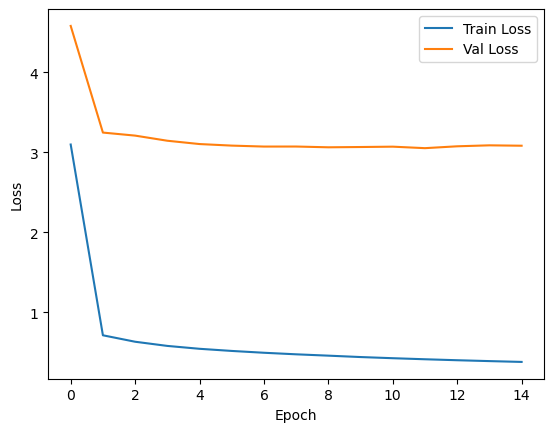

In [3]:
# result_df = pd.DataFrame(columns=['lr','batch','sub','embedding_dim','window_size','val_loss'])

### embedding
dataset = Embedding_Dataset(table_1, table_2, table_3, DEVICE)
dataset_length = len(dataset)
train_size = int(train_ratio * dataset_length)
train_indices = range(0, train_size)
val_size = int(val_ratio * dataset_length)
val_indices = range(train_size, train_size + val_size)
# test_size = int(test_ratio * dataset_length)
# test_indices = range(train_size + val_size, dataset_length)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
# test_dataset = Subset(dataset, test_indices)
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

embedding_model = Embedding(128, 256, 512, embedding_dim, 512, 256, 128).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(embedding_model.parameters(), lr=lr)

embedding_train_losses = []
embedding_val_losses = []

max_early_stop_count = 3
early_stop_count = 0
embedding_best_val_loss = float('inf')
embedding_best_model_weights = None

for epoch in range(epochs):
    embedding_model.train()
    embedding_total_train_loss = 0
    for data in train_dataloader:
        input = data[0].to(DEVICE)
        target = data[1].to(DEVICE)
        output = embedding_model(input).to(DEVICE)

        embedding_train_loss = criterion(output, target)
        embedding_total_train_loss += embedding_train_loss.item()

        optimizer.zero_grad()
        embedding_train_loss.backward()
        optimizer.step()

    embedding_avg_train_loss = embedding_total_train_loss / len(train_dataloader)
    embedding_train_losses.append(embedding_avg_train_loss)

    embedding_model.eval()
    embedding_total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            input = data[0].to(DEVICE)
            target = data[1].to(DEVICE)
            output = embedding_model(input).to(DEVICE)

            embedding_val_loss = criterion(output, target)
            embedding_total_val_loss += embedding_val_loss.item()

    embedding_avg_val_loss = embedding_total_val_loss / len(val_dataloader)
    embedding_val_losses.append(embedding_avg_val_loss)

    if  embedding_best_val_loss > embedding_avg_val_loss:
        embedding_best_val_loss = embedding_avg_val_loss
        embedding_best_model_weights = copy.deepcopy(embedding_model.state_dict())
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= max_early_stop_count:
        print(f'Embedding\t Epoch [{epoch+1}/{epochs}], Train Loss: {embedding_avg_train_loss:.6f}, Val Loss: {embedding_avg_val_loss:.6f} \nEarly Stop Triggered!')
        embedding_model.load_state_dict(embedding_best_model_weights)
        torch.save(embedding_model, f'../데이터/Checkpoint/embedding/embedding_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}.pth')
        break

    print(f'Embedding\t Epoch [{epoch+1}/{epochs}], Train Loss: {embedding_avg_train_loss:.6f}, Val Loss: {embedding_avg_val_loss:.6f}')
    
save_train_val_losses(embedding_train_losses, embedding_val_losses, f'../데이터/Checkpoint/embedding/embedding_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')

### transformer
# embedding_model = 'None'
# embedding_dim = 'None'
dataset = Apartment_Complex_Dataset(embedding_model, table_1, table_2, table_3, embedding_dim, window_size, 'DL', DEVICE)
# embedding_dim = 12
dataset_length = len(dataset)
train_size = int(train_ratio * dataset_length)
train_indices = range(0, train_size)
val_size = int(val_ratio * dataset_length)
val_indices = range(train_size, train_size + val_size)
# test_size = int(test_ratio * dataset_length)
# test_indices = range(train_size + val_size, dataset_length)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
# test_dataset = Subset(dataset, test_indices)
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

transformer_model = Transformer(embedding_dim, 1, 2, 2).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=lr)

transformer_train_losses = []
transformer_val_losses = []

max_early_stop_count = 3
early_stop_count = 0
transformer_best_val_loss = float('inf')
transformer_best_model_weights = None

for epoch in range(epochs):
    transformer_model.train()
    transformer_total_train_loss = 0
    transformer_total_train_num = 1e-9
    for data in train_dataloader:
        src = data[0].to(DEVICE)
        trg = data[1].to(DEVICE)

        if (trg[0] != 0):
            transformer_total_train_num += 1

            src_mask = transformer_model.generate_square_subsequent_mask(src.shape[1]).to(src.device)
            output = transformer_model(src, src_mask)

            transformer_train_loss = criterion(output[0], trg)
            transformer_total_train_loss += transformer_train_loss.item()

            optimizer.zero_grad()
            transformer_train_loss.backward()
            optimizer.step()
            
    transformer_avg_train_loss = transformer_total_train_loss / transformer_total_train_num
    transformer_train_losses.append(transformer_avg_train_loss)

    transformer_model.eval()
    transformer_total_val_loss = 0
    transformer_total_val_num = 1e-9
    with torch.no_grad():
        for data in val_dataloader:
            src = data[0].to(DEVICE)
            trg = data[1].to(DEVICE)

            if (trg[0] != 0):
                transformer_total_val_num += 1

                src_mask = transformer_model.generate_square_subsequent_mask(src.shape[1]).to(src.device)
                output = transformer_model(src, src_mask)

                transformer_val_loss = criterion(output[0], trg)
                transformer_total_val_loss += transformer_val_loss.item()

    transformer_avg_val_loss = transformer_total_val_loss / transformer_total_val_num
    transformer_val_losses.append(transformer_avg_val_loss)

    if  transformer_best_val_loss > transformer_avg_val_loss:
        transformer_best_val_loss = transformer_avg_val_loss
        transformer_best_model_weights = copy.deepcopy(transformer_model.state_dict())
        early_stop_count = 0
    else:
        early_stop_count += 1
        
    if early_stop_count >= max_early_stop_count:
        print(f'Transformer\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_avg_train_loss:.6f}, Val Loss: {transformer_avg_val_loss:.6f} \nEarly Stop Triggered!')
        transformer_model.load_state_dict(transformer_best_model_weights)
        torch.save(transformer_model, f'../데이터/Checkpoint/transformer/transformer_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}.pth')
        break

    print(f'Transformer\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_avg_train_loss:.6f}, Val Loss: {transformer_avg_val_loss:.6f}')

save_train_val_losses(transformer_train_losses, transformer_val_losses, f'../데이터/Checkpoint/transformer/transformer_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')

# embedding_dim = 'None'
### transformer attention
dataset = District_Dataset(embedding_model, table_1, table_2, table_3, embedding_dim, window_size, sub, DEVICE)
# embedding_dim = 12
dataset_length = len(dataset)
train_size = int(train_ratio * dataset_length)
train_indices = range(0, train_size)
val_size = int(val_ratio * dataset_length)
val_indices = range(train_size, train_size + val_size)
# test_size = int(test_ratio * dataset_length)
# test_indices = range(train_size + val_size, dataset_length)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
# test_dataset = Subset(dataset, test_indices)
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

transformer_att_model = TransformerAttention(transformer_model, embedding_dim, 1, DEVICE).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(transformer_att_model.parameters(), lr=lr)

transformer_att_train_losses = []
transformer_att_val_losses = []

max_early_stop_count = 3
early_stop_count = 0
transformer_att_best_val_loss = float('inf')
transformer_att_best_model_weights = None

for epoch in range(epoch):
    transformer_att_model.train()
    transformer_att_total_train_loss = 0
    transformer_att_total_train_num = 1e-9
    for data in train_dataloader:
        src = data[0][0].to(DEVICE)
        max_len = data[1][0].to(DEVICE)
        try:
            anw = torch.nonzero(data[2][0]).to(DEVICE)[0]
        except:
            continue
        trg = data[3][0].to(DEVICE)
        
        transformer_att_total_train_num += len(anw)

        for index in anw:
            output = transformer_att_model(src, index, max_len)
            
            transformer_att_train_loss = criterion(output, trg[index])
            transformer_att_total_train_loss += transformer_att_train_loss.item()
            
            optimizer.zero_grad()
            transformer_att_train_loss.backward()
            optimizer.step() 
            
    transformer_att_avg_train_loss = transformer_att_total_train_loss / transformer_att_total_train_num
    transformer_att_train_losses.append(transformer_att_avg_train_loss)

    transformer_att_model.eval()
    transformer_att_total_val_loss = 0
    transformer_att_total_val_num = 1e-9
    with torch.no_grad():
        for data in val_dataloader:
            src = data[0][0].to(DEVICE)
            max_len = data[1][0].to(DEVICE)
            try:
                anw = torch.nonzero(data[2][0]).to(DEVICE)[0]
            except:
                continue
            trg = data[3][0].to(DEVICE)
            
            transformer_att_total_val_num += len(anw)

            for index in anw:
                output = transformer_att_model(src, index, max_len)

                transformer_att_val_loss = criterion(output, trg[index])
                transformer_att_total_val_loss += transformer_att_val_loss.item()
                
    transformer_att_avg_val_loss = transformer_att_total_val_loss / transformer_att_total_val_num
    transformer_att_val_losses.append(transformer_att_avg_val_loss)
            
    if  transformer_att_best_val_loss > transformer_att_avg_val_loss:
        transformer_att_best_val_loss = transformer_att_avg_val_loss
        transformer_att_best_model_weights = copy.deepcopy(transformer_att_model.state_dict())
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= max_early_stop_count:
        print(f'Attention\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_att_avg_train_loss:.6f}, Val Loss: {transformer_att_avg_val_loss:.6f} \nEarly Stop Triggered!')
        transformer_att_model.load_state_dict(transformer_att_best_model_weights)
        torch.save(transformer_att_model, f'../데이터/Checkpoint/transformer/attention/transformer_attention_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}.pth')
        break

    print(f'Attention\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_att_avg_train_loss:.6f}, Val Loss: {transformer_att_avg_val_loss:.6f}')

save_train_val_losses(transformer_att_train_losses, transformer_att_val_losses, f'../데이터/Checkpoint/attention/transformer/attention_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')

# result_df = result_df.append({
#     'lr': lr,
#     'batch': batch,
#     'sub': sub,
#     'embedding_dim': embedding_dim,
#     'window_size': window_size,
#     'val_loss': min(transformer_att_val_losses),
# }, ignore_index=True)

# result_df = result_df.sort_values('val_loss')
# result_df.to_excel(f'../데이터/Checkpoint/result/result_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}.xlsx')

### test

In [3]:
### transformer attention
embedding_model = torch.load("../데이터/Checkpoint/embedding/ws_3/embedding_lr_0.0001_batch_64_sub_True_emb_1024_ws_3_epochs_13.pth", map_location=DEVICE)
transformer_att_model = torch.load("../데이터/Checkpoint/transformer/attention/ws_3/transformer_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_3_epochs_4.pth", map_location=DEVICE)
dataset = District_Dataset(embedding_model, table_1, table_2, table_3, embedding_dim, window_size, sub, DEVICE)
dataset_length = len(dataset)
train_size = int(train_ratio * dataset_length)
# train_indices = range(0, train_size)
val_size = int(val_ratio * dataset_length)
# val_indices = range(train_size, train_size + val_size)
test_size = int(test_ratio * dataset_length)
test_indices = range(train_size + val_size, dataset_length)
# train_dataset = Subset(dataset, train_indices)
# val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)
# train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

transformer_att_model.eval()
transformer_att_test_rmses = []
transformer_att_test_mses = []
transformer_att_test_maes = []

transformer_att_test_outputs = []
transformer_att_test_trgs = []

with torch.no_grad():
    for data in test_dataloader:
        src = data[0][0].to(DEVICE)
        max_len = data[1][0].to(DEVICE)
        try:
            anw = torch.nonzero(data[2][0]).to(DEVICE)[0]
        except:
            continue
        trg = data[3][0].to(DEVICE)

        for index in anw:
            output = transformer_att_model(src, index, max_len)
            
            transformer_att_test_outputs.append(output)
            transformer_att_test_trgs.append(trg[index])

save_path = f'../데이터/Checkpoint/transformer/attention/ws_3/transformer_attention_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{4}'
with open(f'{save_path}_test_rmses.txt', 'w') as f:
    for item in transformer_att_test_rmses:
        f.write("%s\n" % item)
with open(f'{save_path}_test_mses.txt', 'w') as f:
    for item in transformer_att_test_mses:
        f.write("%s\n" % item)
with open(f'{save_path}_test_maes.txt', 'w') as f:
    for item in transformer_att_test_maes:
        f.write("%s\n" % item)

transformer_att_test_outputs = torch.FloatTensor(transformer_att_test_outputs)
transformer_att_test_trgs = torch.FloatTensor(transformer_att_test_trgs) 

transformer_att_test_rmse = rmse(transformer_att_test_outputs, transformer_att_test_trgs)
transformer_att_test_mse = mse(transformer_att_test_outputs, transformer_att_test_trgs)
transformer_att_test_mae = mae(transformer_att_test_outputs, transformer_att_test_trgs)
        
print(f'Test RMSE: {transformer_att_test_rmse:.4f}')
print(f'Test MSE: {transformer_att_test_mse:.4f}')
print(f'Test MAE: {transformer_att_test_mae:.4f}')

query: torch.Size([1024, 1])
att: torch.Size([1024])
s: torch.Size([2048])
query: torch.Size([1024, 1])
att: torch.Size([1024])
s: torch.Size([2048])
query: torch.Size([1024, 1])
att: torch.Size([1024])
s: torch.Size([2048])
query: torch.Size([1024, 1])
att: torch.Size([1024])
s: torch.Size([2048])
query: torch.Size([1024, 1])
att: torch.Size([1024])
s: torch.Size([2048])
query: torch.Size([1024, 1])
att: torch.Size([1024])
s: torch.Size([2048])
query: torch.Size([1024, 1])
att: torch.Size([1024])
s: torch.Size([2048])
query: torch.Size([1024, 1])
att: torch.Size([1024])
s: torch.Size([2048])
query: torch.Size([1024, 1])
att: torch.Size([1024])
s: torch.Size([2048])
query: torch.Size([1024, 1])
att: torch.Size([1024])
s: torch.Size([2048])
query: torch.Size([1024, 1])
att: torch.Size([1024])
s: torch.Size([2048])
query: torch.Size([1024, 1])
att: torch.Size([1024])
s: torch.Size([2048])
query: torch.Size([1024, 1])
att: torch.Size([1024])
s: torch.Size([2048])
query: torch.Size([1024, 